In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [ ]:
# If you don't have the file data/all_cleaned.csv then please uncomment this line:
# %run EDA_Alida.ipynb

In [4]:
all_cleaned = pd.read_csv('data/all_cleaned.csv')

#### Content-based filtering: recommending books based on book titles ####

In [5]:
all_cleaned

,isbn,book_title,book_author,year_of_publication,publisher,genre,user_id,book_rating,location,age,age_numeric,age_bins,mod_book_author,mod_book_title,mod_publisher,country
0,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,16634.0,0.0,"little rock, arkansas, usa",42.0,42.0,Adult,kitty kelley,the royals,bausch lombard,usa
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,87141.0,0.0,"huntington beach, california, usa",unknown,NaN,unknown,kitty kelley,the royals,bausch lombard,usa
2,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,169736.0,7.0,"minneapolis, minnesota, usa",34.0,34.0,Adult,kitty kelley,the royals,bausch lombard,usa
3,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,208406.0,0.0,"kansas city, missouri, usa",30.0,30.0,Adult,kitty kelley,the royals,bausch lombard,usa
4,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,230496.0,0.0,"simi valley, california, usa",34.0,34.0,Adult,kitty kelley,the royals,bausch lombard,usa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183595,684719274,Ethan Frome,Edith Wharton,1910,Scribner Book Company,"Accident victims, American fiction (fictional ...",127035.0,0.0,"fayetteville, ,",52.0,52.0,Mature,edith wharton,ethan frome,scribner book company,NaN
183596,038528120X,CATCH 22,JOSEPH HELLER,1904,Delta,"Open Library Staff Picks, Satire, War stories,...",25700.0,10.0,"greenhills, ohio, usa",unknown,NaN,unknown,joseph heller,catch 22,delta,usa
183597,B0000VZEFK,Is That a Gun in Your Pocket?: Women's Experie...,Rachel Abramowitz,1900,Random House,unknown,56856.0,0.0,"escondido, california, usa",23.0,23.0,Adult,rachel abramowitz,is that a gun in your pocket womens experience...,random house,usa
183598,1551103982,The Cycling Adventures of Coconut Head: A Nort...,Ted Schredd,1900,Graphic Arts Center Pub Co,"Bicycle touring, Description and travel, Journ...",101606.0,7.0,"niagara falls, ontario, canada",32.0,32.0,Adult,ted schredd,the cycling adventures of coconut head a north...,graphic arts center pub co,canada


<Axes: xlabel='mod_book_title'>

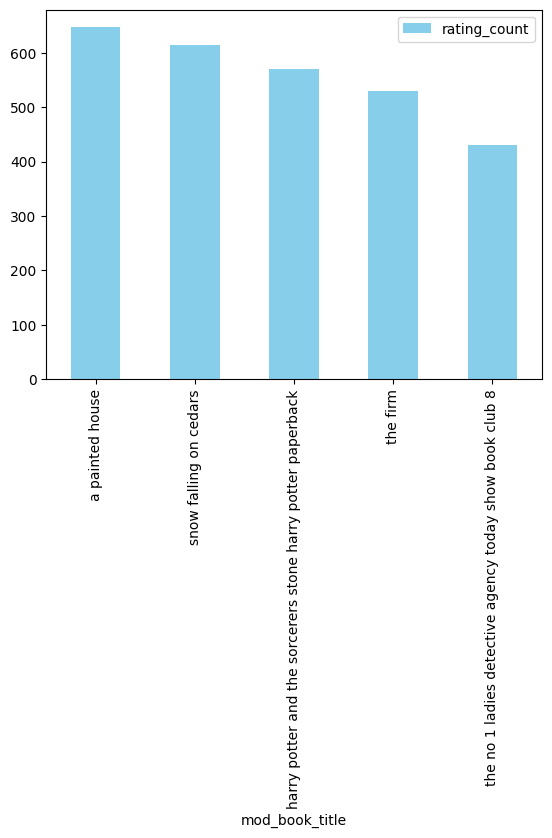

In [6]:
# Group by 'isbn' and count the number of ratings for each ISBN
isbn_rating_counts = all_cleaned.groupby(['mod_book_title', 'book_author', 'isbn']).size().reset_index(name='rating_count')

# Display the DataFrame to verify the result
isbn_rating_counts.sort_values('rating_count', ascending=False).head().plot(kind='bar', x='mod_book_title', y='rating_count', color='skyblue')

In [7]:
isbn_rating_counts.head()

,mod_book_title,book_author,isbn,rating_count
0,0815 heute,Kirst,3442013453,1
1,1 2 3,Tana Hoban,068802579X,3
2,10 000 dreams interpreted,Gustavus Hindman Miller,1862044082,1
3,100 chocolate,Katherine Khodorowsky,1577173074,1
4,1000 years 1000 people ranking the men and wom...,Agnes Hooper Gottlieb,1568362536,4


In [18]:
# including the average rating for each book
# Calculate the average rating for each book

to_be_rated = all_cleaned[['isbn', 'book_rating']]
averageRating = to_be_rated.groupby('isbn')['book_rating'].mean().round(1).reset_index()
averageRating.rename(columns={'book_rating': 'average_rating'}, inplace=True)
average_rating = averageRating[['isbn','average_rating']]

# Merge the average ratings back with the original dataset
averageRatingdf = pd.merge(isbn_rating_counts, average_rating, on='isbn', how='left')

# Remove duplicate entries
#averageRatingdf = averageRatingdf[['isbn', 'average_rating']].drop_duplicates(subset=['isbn'])

averageRatingdf.head()  

,mod_book_title,book_author,isbn,rating_count,average_rating
0,006781 bk1 gags de boule et bil,ROBA,2266022253,1,10.0
1,010100 a novel of the millennium,R. J. Pineiro,0312870582,10,3.2
2,010100 the novel of the millennium,R. J. Pineiro,0812568710,22,2.8
3,0815 heute,Kirst,3442013453,1,7.0
4,0911 848 am documenting americas greatest tragedy,Ethan Casey (editor) BlueEar.com,1591090113,1,0.0


<Axes: ylabel='rating_count'>

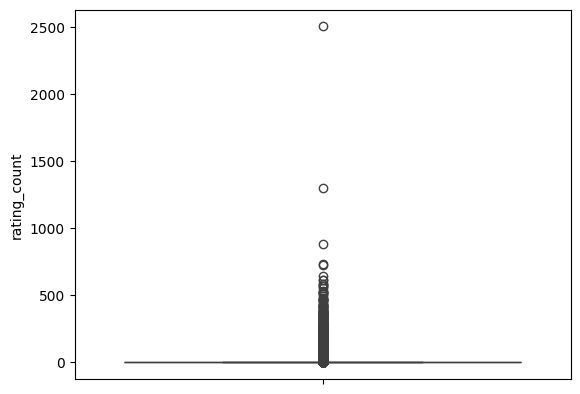

In [19]:
sns.boxplot(averageRatingdf.rating_count)

In [21]:
averageRatingdf['mod_book_title'].nunique()

235210

In [22]:
# Reducing shape of dataframe

ratings = averageRatingdf[averageRatingdf['rating_count'] >= 15]    #filtering out books with less than 15 ratings
ratings.shape

(10394, 5)

In [24]:
# turning titles into TD-IDF matrix => Term Frequency-Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer takes a list of strings as input and turns it into a fd-idf matrix
vectorizer = TfidfVectorizer()

tdidf = vectorizer.fit_transform(ratings['mod_book_title'])

In [25]:
# to do comparison between books, we need to calculate the cosine similarity between the books

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re


# query function:

def search(query, vectorizer):
# setting up a search query

    #query = 'The Hobbit'
# preparing the string in the same way as the mod titles above
    processed = re.sub('[^a-zA-Z0-9]', ' ', query.lower())

# we need to turn the query into a vector using the vectorizer

    query_vector = vectorizer.transform([processed])

# to find the similarities we calculate the cosine similarity between the query vector and the tdidf matrix
    similarity = cosine_similarity(query_vector, tdidf).flatten() # flatten is used to turn the matrix into a 1D array

# to find the indices of the 10 largest similarities

    indices = np.argpartition(similarity, -10)[-10:]

# use indices to index the titles

    results = ratings.iloc[indices]   

# as there are many books with the title "The Hobbit", we only want those with the highest number of ratings

    results = results.sort_values(by='rating_count', ascending=False)

    return results.head(10)


In [26]:
search('lord of the rings', vectorizer)    

,mod_book_title,book_author,isbn,rating_count,average_rating
209932,the fellowship of the ring the lord of the rin...,J.R.R. TOLKIEN,0345339703,257,4.5
238491,the two towers the lord of the rings part 2,J.R.R. TOLKIEN,0345339711,177,4.3
230483,the return of the king the lord of the rings p...,J.R.R. TOLKIEN,0345339738,173,4.2
209926,the fellowship of the ring the lord of the rin...,J. R. R. Tolkien,0618002227,63,6.2
238485,the two towers the lord of the rings part 2,J. R. R. Tolkien,0618002235,39,6.2
28582,bored of the rings a parody of jrr tolkiens th...,Harvard Lampoon Staff,0451452615,31,3.2
230477,the return of the king the lord of the rings p...,J. R. R. Tolkien,0618002243,28,5.5
209927,the fellowship of the ring the lord of the rin...,J. R. R. Tolkien,0618129030,24,5.7
238486,the two towers the lord of the rings part 2,J. R. R. Tolkien,0618129081,19,5.9
238478,the two towers lord of the rings paperback,J. R. R. Tolkien,0345296060,17,3.8
